# Utilities

In [5]:
import os, sys
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('.')))
sys.path.append(parent_dir)

In [378]:
import matplotlib.pyplot as plt
import numpy as np

class Analyzer:
    
    def __init__(self, network):
        self.network = network
        
    def get_degree_distribution(self):
        "Returns the plot of the degree distribution with a log-log scale"
        
        N = self.network.number_of_nodes()
        degrees = [self.network.in_degree(n) for n in self.network.nodes()] if self.network.is_directed() else [self.network.degree(n) for n in self.network.nodes()]
        
        N_k = {}
        for k in degrees:
            if k not in N_k:
                N_k[k] = 1
            else:
                N_k[k] += 1
                
        p_k = {}
        for k in N_k:
            p_k[k] = N_k[k] / N
        
        # Plotting in log-log scale
        plt.figure(figsize=(8, 6))
        plt.loglog(list(p_k.keys()), list(p_k.values()), marker='o', linestyle='None', color='b')
        plt.title('Log-log Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.grid(True)

        return plt

# Random Graphs

In [ ]:
from networks_gen import randomG
import random

n = 25000

# take p randomly between 1/24999 and 1
p = random.uniform(1/(n-1), 0.01)

g1 = randomG(n, p)
analyzer_g1 = Analyzer(g1)
plt = analyzer_g1.get_degree_distribution()
plt.show()

In [ ]:
print(len(g1.edges()))
print(len(g1.nodes()))

In [ ]:
# save the graph
print(p)

In [ ]:
# save the graph
print(stream_diam(g1))

# Configuration model

In [ ]:
import networkx as nx
import numpy as np

degree_distribution = [d for _, d in G.degree()]

min = np.min(degree_distribution)
max = np.max(degree_distribution)

# normalize the degree distribution beteen 0 and max - min
normalized_degree_distribution = [d - min for d in degree_distribution]

if np.sum(normalized_degree_distribution) % 2 != 0:
    normalized_degree_distribution[0] += 1

# Generate the small graph
small_graph = nx.configuration_model(normalized_degree_distribution[:3000])

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

In [ ]:
nx.draw_networkx(small_graph, with_labels=False, linewidths=0.01, node_size=1, width=0.1)
plt.show()

# Preferential Attachment

In [ ]:
from networks_gen import preferentialG
import random

# generate a preferential graph for n = 25000 and different values of p (between 0 excluded and 1 included) and plot the degree distribution for each graph
n = 25000

ps = [0.01, 0.1, 0.5, 0.7, 1]

# take p randomly between 1/24999 and 1
for p in ps:
    g2 = preferentialG(n, p)
    analyzer_g2 = Analyzer(g2)
    print(len(g2.edges()))
    plt = analyzer_g2.get_degree_distribution()
    plt.show()

# Generalized Watts-Strogatz

In [ ]:
import networkx as nx
import numpy as np
from networks_gen import GenWS2DG

# degree_distribution = [d for _, d in G.degree()]

# min = np.min(degree_distribution)
# max = np.max(degree_distribution)

# # normalize the degree distribution beteen 0 and max - min
# normalized_degree_distribution = [d - min for d in degree_distribution]

# normalized_degree_distribution = normalized_degree_distribution[:3000]

# if np.sum(normalized_degree_distribution) % 2 != 0:
#     normalized_degree_distribution[-1] += 1

# Generate the small graph
small_graph = GenWS2DG(2500, 1, 1000, 1)

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

# Affiliation Networks

In [384]:
import networkx as nx

G = nx.read_edgelist('net_2', nodetype=int)

In [701]:
from networks_gen import affiliationG
import math
import networkx as nx

G = affiliationG(100, 4, 0.1, 2, 0.2, 1)


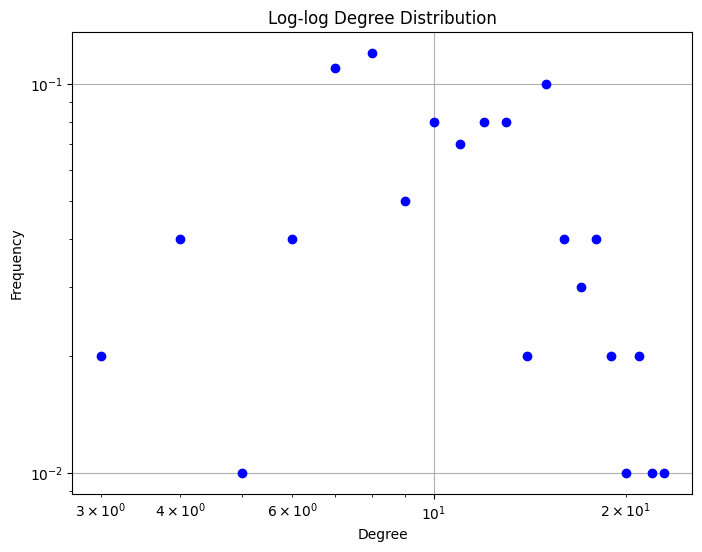

In [702]:
analyzer_g1 = Analyzer(G)
plt = analyzer_g1.get_degree_distribution()
plt.show()

In [703]:
n = len(G.nodes())
m = range(2, 10)
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
s = 1

In [704]:
import numpy as np
import math

def log_likelihood(u, F, G, sum_v, i):
    
    sum_1 = np.zeros(i)
    for v in G.neighbors(u):
        dot_product = np.dot(F[u], np.transpose(F[v]))
        denominator = 1 - math.exp(-dot_product)
        sum_1 += (F[v] * np.exp(-dot_product) / denominator)

    sum_2 = sum_v - F[u] - np.sum(F[list(G.neighbors(u))], axis=0)

    return sum_1 - sum_2

def coordinate_gradient_ascent(log_likelihood, F, G, sum_v, learning_rate, max_iter):
    
    n, m = F.shape

    while max_iter > 0:
        
        tot_gradient = np.zeros(m)
        new_F = np.zeros((n, m))
        
        for u in range(n):
            gradient_u = log_likelihood(u, F, G, sum_v, m)
            tot_gradient += gradient_u
            new_F[u] = F[u] + learning_rate * gradient_u
            new_F[u] = np.maximum(new_F[u], 0)
            
        F = new_F
        sum_v = np.sum(F, axis=0)
        
        max_iter -= 1
        
        if np.sum(np.abs(tot_gradient)) < 0.0001:
            break
        
    return F


In [705]:
import math

def compute_c(G, m):
    
    n = len(G.nodes())
    learning_rate = 0.0001
    max_iter = 1000

    F = np.random.rand(n, m)
    sum_v = np.sum(F, axis=0)
    
    F = coordinate_gradient_ascent(log_likelihood, F, G, sum_v, learning_rate, max_iter)
    
    mean = np.mean(F)

    affiliations, communities = {}, {}
    for u in range(n):
        affiliations[u] = [i for i in range(m) if F[u][i] > mean]
        for i in affiliations[u]:
            if i not in communities:
                communities[i] = [u]
            else:
                communities[i].append(u)

    # compute the number of elements > 0.01 per-row and make the mean
    mean_length = np.mean(np.sum(F > 0.0099, axis=1))
    
    return math.ceil(mean_length), affiliations

def compute_p(G, affiliations):

    num_strong_ties_per_node = [degree-1 for _, degree in G.degree()]
    
    # compute the number of edges each nodes has with nodes in the same community
    num_strong_ties_per_community = {}
    for u in affiliations:
        num_strong_ties_per_community[u] = {}
        for i in affiliations[u]:
            for neighbor in G.neighbors(u):
                if i in affiliations[neighbor]:
                    if i not in num_strong_ties_per_community[u]:
                        num_strong_ties_per_community[u][i] = 1
                    else:
                        num_strong_ties_per_community[u][i] += 1
                    
    # compute the probability p of a node to have an edge towards a community
    p = {}
    for u in num_strong_ties_per_community:
        p[u] = {}
        for i in num_strong_ties_per_community[u]:
            p[u][i] = num_strong_ties_per_community[u][i] / num_strong_ties_per_node[u]
            
    mean_p = np.mean([p[u][i] for u in p for i in p[u]])
    
    return mean_p
    

In [706]:
import math

def compute_degree_distance(G1, G2):

    degree_distribution_G1 = [d for _, d in G1.degree()]
    degree_distribution_G2 = [d for _, d in G2.degree()]
        
    return sum([abs(degree_distribution_G1[i] - degree_distribution_G2[i]) for i in range(len(degree_distribution_G1))])

best_dist = float('inf')

early_stopping = 5

j = q[0]

for i in m:
    
    c, communities = compute_c(G, i)
    
    p = 0.2

    for j in q:
            
        G2 = affiliationG(n, i, j, c, p, s)
        
        dist = compute_degree_distance(G, G2)
        print("m = {}, q = {}, c = {}, p = {}, dist = {}".format(i, j, c, p, dist))
        
        if dist < best_dist:
            best_dist = dist
            best_params = [i, j, c, p]
            
        if abs(dist - best_dist) < 0.001 or early_stopping == 0:
            early_stopping = 5
            break
        
        elif dist > best_dist and early_stopping > 0:
            early_stopping -= 1
                    
print(best_params, best_dist)

m = 2, q = 0.1, c = 2, p = 0.2, dist = 854
m = 3, q = 0.1, c = 2, p = 0.2, dist = 552
m = 4, q = 0.1, c = 3, p = 0.2, dist = 768
m = 4, q = 0.2, c = 3, p = 0.2, dist = 788
m = 4, q = 0.3, c = 3, p = 0.2, dist = 776
m = 4, q = 0.4, c = 3, p = 0.2, dist = 844
m = 4, q = 0.5, c = 3, p = 0.2, dist = 768
m = 4, q = 0.6, c = 3, p = 0.2, dist = 612
m = 5, q = 0.1, c = 3, p = 0.2, dist = 566
m = 5, q = 0.2, c = 3, p = 0.2, dist = 590
m = 5, q = 0.3, c = 3, p = 0.2, dist = 918
m = 5, q = 0.4, c = 3, p = 0.2, dist = 754
m = 5, q = 0.5, c = 3, p = 0.2, dist = 580
m = 5, q = 0.6, c = 3, p = 0.2, dist = 1026
m = 6, q = 0.1, c = 3, p = 0.2, dist = 592
m = 6, q = 0.2, c = 3, p = 0.2, dist = 550
m = 7, q = 0.1, c = 4, p = 0.2, dist = 850
m = 7, q = 0.2, c = 4, p = 0.2, dist = 786
m = 7, q = 0.3, c = 4, p = 0.2, dist = 650
m = 7, q = 0.4, c = 4, p = 0.2, dist = 640
m = 7, q = 0.5, c = 4, p = 0.2, dist = 1748
m = 7, q = 0.6, c = 4, p = 0.2, dist = 1244
m = 8, q = 0.1, c = 4, p = 0.2, dist = 602
m = 8, q

In [707]:
# 4, 0.1, 3, 0.2

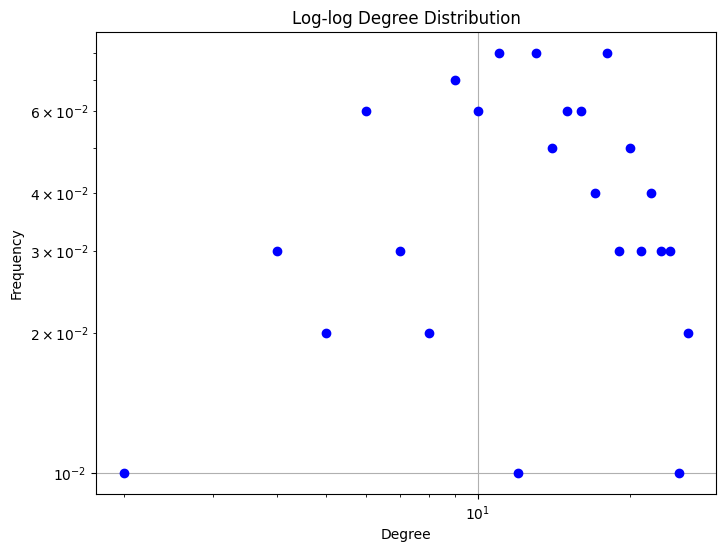

In [708]:
G2 = affiliationG(n, math.floor(best_params[0]), best_params[1], best_params[2], best_params[3], s)

analyzer_g2 = Analyzer(G2)
plt = analyzer_g2.get_degree_distribution()
plt.show()